In [1]:
from pyspark.sql import functions as F
from pyspark.sql import DataFrameNaFunctions as DFna
from pyspark.sql.functions import udf, col, when
import matplotlib.pyplot as plt
import pyspark as ps
import os, sys, requests, json


In [2]:
spark = ps.sql.SparkSession.builder \
            .master("local") \
            .appName("building recommender") \
            .getOrCreate() # create a spark session
            
sc = spark.sparkContext # create a spark context

In [3]:
# read movies CSV
movies_df = spark.read.csv('data/movies/movies.csv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep=",",           # char for separation
                         inferSchema=True)  # do we infer schema or not ?
movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [4]:
print("line count: {}".format(movies_df.count()))

line count: 9125


In [5]:
# read ratings CSV
ratings_df = spark.read.csv('data/movies/ratings.csv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep=",",           # char for separation
                         inferSchema=True)  # do we infer schema or not ?
ratings_df.printSchema()



root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



Lets see how many distinct ratings, users and movies we have total

In [6]:
ratings = ratings_df

numRatings = ratings.count()
numUsers = ratings.select("userId").distinct().count()
numMovies = ratings.select("movieId").distinct().count()

print( "Got %d ratings from %d users on %d movies." % (numRatings, numUsers, numMovies))

Got 100004 ratings from 671 users on 9066 movies.


Next we will get the counts of ratings for each movie and show the top 20.

In [7]:
movies_counts = ratings_df.groupBy(col("movieId")).agg(F.count(col("rating")).alias("counts"))
movies_counts.show()

+-------+------+
|movieId|counts|
+-------+------+
|   1580|   190|
|   2659|     3|
|   3794|     5|
|   3175|    65|
|    471|    49|
|   1088|    53|
|   1342|    17|
|   1645|    60|
|   2366|    23|
|   6620|    17|
|   8638|    17|
|  96488|     4|
| 160563|     2|
|   7982|     3|
|   1238|    17|
|   1959|    30|
|    463|     7|
|   2122|    11|
|   1591|    15|
|   5518|     1|
+-------+------+
only showing top 20 rows



Show's .5 increment ratings being chosen with less frequency than whole number values. This is an indicator that perhaps people don't know they can rate in increments of .5. Perhaps this is more indicative of a interface problem with the website rather than the users actual opinion of the movie

In [8]:
# ratingsRDD = ratings_df.rdd.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),
#                                      rating=float(p[2])))


OK let's get something working!
First I will split the data in to a training, validation and test set

In [9]:
ratings_df.take(3)

[Row(userId=1, movieId=31, rating=2.5, timestamp=1260759144),
 Row(userId=1, movieId=1029, rating=3.0, timestamp=1260759179),
 Row(userId=1, movieId=1061, rating=3.0, timestamp=1260759182)]

In [10]:
training_df, validation_df, test_df = ratings_df.randomSplit([.6, .2, .2], seed=0)
# training_RDD = training_RDD.rdd.cache()
# validation_for_predict_RDD = validation_RDD.rdd.map(lambda x: (x[0], x[1])).cache()
# test_for_predict_RDD = test_RDD.rdd.map(lambda x: (x[0], x[1])).cache()
training_df

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

In [11]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import Row
import numpy as np
import math

First I'll try an alternating least squares estimator with the following initial parameters. I'll iterate over the ranks and pick the best model. For error checking I am using Root mean squared error.

In [12]:
seed = 5
iterations = 10
regularization_parameter = 0.1
ranks = range(4, 12)
errors = []
err = 0
tolerance = 0.02

In [13]:
min_error = float('inf')
best_rank = -1
best_iteration = -1

for rank in ranks:
    als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=rank, userCol="userId", itemCol="movieId", ratingCol="rating")
    model = als.fit(training_df)
    predictions = model.transform(validation_df)
    new_predictions = predictions.filter(col('prediction') != np.nan)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = evaluator.evaluate(new_predictions)
    errors.append(rmse)

    print ('For rank %s the RMSE is %s' % (rank, rmse))
    if rmse < min_error:
        min_error = rmse
        best_rank = rank
print ('The best model was trained with rank %s' % best_rank)



For rank 4 the RMSE is 0.9446644179611068
For rank 5 the RMSE is 0.9481170469360658
For rank 6 the RMSE is 0.9483248728749484
For rank 7 the RMSE is 0.9497387510012897
For rank 8 the RMSE is 0.9457278089246991
For rank 9 the RMSE is 0.943624593955336
For rank 10 the RMSE is 0.9438592519443687
For rank 11 the RMSE is 0.9509672087238684
The best model was trained with rank 9


Now we will build a CrossValidator to evaluate over the same range of ranks with different regularization constants. I will use sparks CrossValidator class. The CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator. The Estimator we will be using is ALS, same as above. We use a ParamGridBuilder to construct a grid of parameters to search over. With 2 values for als.regParam and 8 values for als.rank, this grid will have 2 x 8 = 16 parameter settings for CrossValidator to choose from.



In [14]:
als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=rank, userCol="userId", itemCol="movieId", ratingCol="rating")
paramGrid = ParamGridBuilder() \
    .addGrid(als.regParam, [0.1, 0.01]) \
    .addGrid(als.rank, range(4, 12)) \
    .build()
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(training_df)

In [44]:
cvModel_pred = cvModel.transform(validation_df)
cvModel_pred = cvModel_pred.filter(col('prediction') != np.nan)
rmse = evaluator.evaluate(cvModel_pred)
print ("the rmse for optimal grid parameters with cross validation is: {}".format(rmse))

the rmse for optimal grid parameters with cross validation is: 0.9446644179611068


The grid search doesn't perform as well as the above for some reason. I'll use the following final model.

In [45]:
final_als = ALS(maxIter=10, regParam=0.1, rank=6, userCol="userId", itemCol="movieId", ratingCol="rating")
final_model = final_als.fit(training_df)
final_pred = final_model.transform(validation_df)
final_pred = final_pred.filter(col('prediction') != np.nan)
rmse = evaluator.evaluate(final_pred)
print ("the rmse for optimal grid parameters with cross validation is: {}".format(rmse))

the rmse for optimal grid parameters with cross validation is: 0.9483248728749484


In [46]:
# read links CSV
links_df = spark.read.csv('data/movies/links.csv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep=",",           # char for separation
                         inferSchema=True)  # do we infer schema or not ?
links_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)



Let's now take a hyptothetical user that has already rated some movies. I'll take a random user_id out the range of user id's in the dataset. Next, I get all of their ratings and sort to show the top 10 rated movies.

In [47]:
np.random.seed(42)
user_id = np.random.choice(numUsers)

In [48]:
new_user_ratings = ratings_df.filter(ratings_df.userId == user_id)
new_user_ratings.sort('rating', ascending=True).take(10) # top rated movies for this user

[Row(userId=102, movieId=37, rating=1.0, timestamp=959976593),
 Row(userId=102, movieId=1888, rating=1.0, timestamp=957895013),
 Row(userId=102, movieId=2240, rating=1.0, timestamp=957894741),
 Row(userId=102, movieId=2541, rating=1.0, timestamp=957894760),
 Row(userId=102, movieId=2548, rating=1.0, timestamp=957980378),
 Row(userId=102, movieId=3354, rating=1.0, timestamp=957893451),
 Row(userId=102, movieId=3484, rating=1.0, timestamp=957893428),
 Row(userId=102, movieId=3511, rating=1.0, timestamp=957893428),
 Row(userId=102, movieId=1584, rating=2.0, timestamp=957894285),
 Row(userId=102, movieId=590, rating=2.0, timestamp=957894532)]

In [49]:
new_user_ratings.describe('rating').show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|               678|
|   mean|3.9749262536873156|
| stddev|0.8529848074277973|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



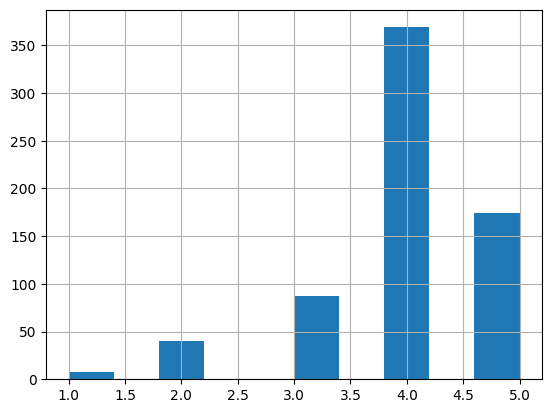

In [50]:
new_user_ratings.toPandas()['rating'].hist()
plt.show()

This is interesting, the users ratings are skewed to the high side. The following will get a list of all unrated movieIds with more than 25 ratings.

In [51]:
new_user_rated_movieIds = [i.movieId for i in new_user_ratings.select('movieId').distinct().collect()]
movieIds = [i.movieId for i in movies_counts.filter(movies_counts.counts > 25).select('movieId').distinct().collect()]
new_user_unrated_movieIds = list(set(movieIds) - set(new_user_rated_movieIds))

Lets now take all the unrated movie id's for this user and create a spark dataframe with 0 for the predicted rating.

In [52]:
import time
num_ratings = len(new_user_unrated_movieIds)
cols = ('userId', 'movieId', 'timestamp')
timestamps = [int(time.time())] * num_ratings
userIds = [user_id] * num_ratings
ratings = [0] * num_ratings
new_user_preds = spark.createDataFrame(zip(userIds, new_user_unrated_movieIds, timestamps), cols)

In [53]:
new_user_preds = final_model.transform(new_user_preds).filter(col('prediction') != np.nan)

In [54]:
# new_user_preds.sort('prediction', ascending=False).take(10)
# new_user_preds.sort('prediction', ascending=False)
new_user_preds.sort('prediction', ascending=False)
# new_user_preds.toDF()
# new_user_preds.toPandas().hist()
# plt.show()

DataFrame[userId: bigint, movieId: bigint, timestamp: bigint, prediction: float]

We can search for movie posters by id in the movie database and then grab links to the image files from themoviedb.org. The API key is necessary for querying the API. I store it in an environment variable, so if you want to reproduce this, you have to register on themoviedb.org.

In [55]:
# Get base url filepath structure. w185 corresponds to size of movie poster.
api_key = "b3dadf36f3a54b7e016ecb826e0ec0a1"

headers = {'Accept': 'application/json'}
payload = {'api_key': api_key} 
response = requests.get("http://api.themoviedb.org/3/configuration", params=payload, headers=headers)
response = json.loads(response.text)
base_url = response['images']['base_url'] + 'w185'

def get_poster(tmdb_id, base_url):
    
    # Query themoviedb.org API for movie poster path.
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(tmdb_id)
    headers = {'Accept': 'application/json'}
    payload = {'api_key': api_key} 
    response = requests.get(movie_url, params=payload, headers=headers)
    file_path = json.loads(response.text)['posters'][0]['file_path']
    return base_url + file_path

In [56]:
from IPython.display import Image
from IPython.display import display

Now that we have a pipeline to go directly from the TheMovieDB id to the url to displaying the movie poster. With this machinery in hand lets first get the top rated movies the user has already rated:

In [57]:
new_user_ratings = new_user_ratings.sort('rating', ascending=False).join(links_df, new_user_ratings.movieId == links_df.movieId)

In [58]:
posters = tuple(Image(url=get_poster(movie.tmdbId, base_url)) for movie in new_user_ratings.take(5))

In [59]:
display(*posters)

Cool, now let's see what top recommendations are for this user.

In [60]:
new_user_preds = new_user_preds.sort('prediction', ascending=False).join(links_df, new_user_preds.movieId == links_df.movieId)

In [66]:
import jdk
posters = tuple(Image(url=get_poster(movie.tmdbId, base_url)) for movie in new_user_preds.take(5))

Py4JJavaError: An error occurred while calling o17066.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 8156.0 failed 1 times, most recent failure: Lost task 0.0 in stage 8156.0 (TID 24480) (192.168.1.11 executor driver): java.io.IOException: Cannot run program "C:\Users\LENOVO\AppData\Local\Programs\Python\Python311": CreateProcess error=5, Access is denied
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1143)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1073)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:181)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: java.io.IOException: CreateProcess error=5, Access is denied
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:499)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:158)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1110)
	... 36 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.io.IOException: Cannot run program "C:\Users\LENOVO\AppData\Local\Programs\Python\Python311": CreateProcess error=5, Access is denied
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1143)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1073)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:181)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: java.io.IOException: CreateProcess error=5, Access is denied
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:499)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:158)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1110)
	... 36 more


In [ ]:
display(*posters)

And just out of curriosity lets look at the distribution of predicted ratings

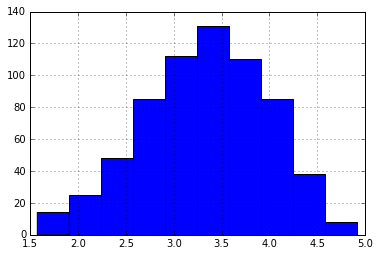

In [ ]:
new_user_preds.toPandas()['prediction'].hist()
plt.show()

This show that the distribution of ratings assumes a gaussian near the mean of the users original ratings distribution 

This code proves we can take a sample of user ratings and using Apache Spark's ML library, train a model to give recomendations for a user that has previously rated movies on the site. If I were going to predict ratings for a new user. I would have a user interface available to take some initial ratings of a number of movies. From these initial reviews, I would form a spark dataframe object to transform with the trained ALS estimator. Some follow on work to this model could be a temporal model where we take into account the trend in user ratings over time to try and better predict future ratings.